https://www.capitalbikeshare.com/

https://www.kaggle.com/marklvl/bike-sharing-dataset

In [1]:
# Import Package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 999
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from skopt import BayesSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, median_absolute_error

In [2]:
df = pd.read_csv('hour.csv',index_col=0)
df.head()
# Import File csv

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
# Pre-Procesing
df['yr'] = df['yr'].map({0:2011, 1:2012})
df['temp']=(df['temp']*(39+8)-8).round(2)
df['atemp']=(df['atemp']*(50+16)-16).round(2)
df['hum']=(df['hum']*100).round(2)
df['windspeed']=(df['windspeed']*67).round(2)
Q1 = df['cnt'].describe()['25%']
Q3 = df['cnt'].describe()['75%']
IQR = Q3 - Q1
upper_fence = Q3 + (1.5*IQR)
lower_fence = Q1 - (1.5*IQR)
df['event'] = df['cnt'].apply(lambda x: 0 if (x > lower_fence)&(x < upper_fence) else 1)
df

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,event
instant,,,,,,,,,,,,,,,,,
1,2011-01-01,1,2011,1,0,0,6,0,1,3.28,3.0,81.0,0.0,3,13,16,0
2,2011-01-01,1,2011,1,1,0,6,0,1,2.34,2.0,80.0,0.0,8,32,40,0
3,2011-01-01,1,2011,1,2,0,6,0,1,2.34,2.0,80.0,0.0,5,27,32,0
4,2011-01-01,1,2011,1,3,0,6,0,1,3.28,3.0,75.0,0.0,3,10,13,0
5,2011-01-01,1,2011,1,4,0,6,0,1,3.28,3.0,75.0,0.0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17375,2012-12-31,1,2012,12,19,0,1,1,2,4.22,1.0,60.0,11.0,11,108,119,0
17376,2012-12-31,1,2012,12,20,0,1,1,2,4.22,1.0,60.0,11.0,8,81,89,0
17377,2012-12-31,1,2012,12,21,0,1,1,1,4.22,1.0,60.0,11.0,7,83,90,0


## Data Preparation

In [4]:
df.columns

Index(['dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'event'],
      dtype='object')

In [5]:
df_ML = df[['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'atemp', 'hum', 'windspeed', 'cnt','event']]
df_ML.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt,event
instant,,,,,,,,,,,,,
1,1,2011,1,0,0,6,0,1,3.0,81.0,0.0,16,0
2,1,2011,1,1,0,6,0,1,2.0,80.0,0.0,40,0
3,1,2011,1,2,0,6,0,1,2.0,80.0,0.0,32,0
4,1,2011,1,3,0,6,0,1,3.0,75.0,0.0,13,0
5,1,2011,1,4,0,6,0,1,3.0,75.0,0.0,1,0


In [6]:
X = df_ML.drop(columns='cnt')
y = df_ML['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=36)

## Base Model

In [7]:
num_columns = ['yr', 'atemp', 'hum', 'windspeed']
cat_columns = ['season', 'mnth', 'hr','holiday', 'weekday','workingday', 'weathersit','event']

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
])

categoric_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy='most_frequent')),
])

preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns),
    ('categorical', categoric_pipeline, cat_columns)
])

pipe_DT_Base = Pipeline([
    ('prep', preprocessor),
    ('algo', DecisionTreeRegressor(random_state=36)),
])

pipe_RF_Base = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(random_state=36)),
])

pipe_XGB_Base = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(random_state=36)),
])

## Evaluation Matrix Base Model

In [8]:
def Eva_Matrix(Model, X, y_true):
    y_pred = Model.predict(X)
    R2 = r2_score(y_true, y_pred)*100
    MAE = mean_absolute_error(y_true, y_pred)
    MSE = mean_squared_error(y_true, y_pred)
    RMSE = np.sqrt(MSE)
    MedAE = median_absolute_error(y_true, y_pred)
    return R2, MAE, MSE, RMSE, MedAE

### DecisionTree

In [9]:
pipe_DT_Base.fit(X_train,y_train)
R2_train_DT,MAE_train_DT,MSE_train_DT,RMSE_train_DT, MedAE_train_DT = Eva_Matrix(pipe_DT_Base, X_train,y_train)
R2_test_DT,MAE_test_DT,MSE_test_DT,RMSE_test_DT, MedAE_test_DT = Eva_Matrix(pipe_DT_Base, X_test,y_test)
dataDT = {
    'Training':[R2_train_DT,MAE_train_DT,MSE_train_DT,RMSE_train_DT,MedAE_train_DT],
    'Testing':[R2_test_DT,MAE_test_DT,MSE_test_DT,RMSE_test_DT, MedAE_test_DT]
}
pd.DataFrame(data=dataDT, index=["R Squared", "MAE", "MSE", "RMSE","MedAE"])

,Training,Testing
R Squared,99.999884,90.023868
MAE,0.002915,34.598964
MSE,0.037901,3308.480380
RMSE,0.194681,57.519391
MedAE,0.000000,19.000000


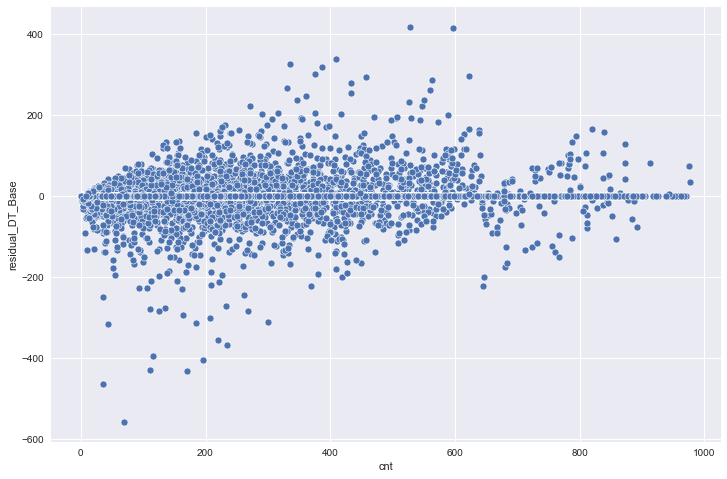

In [10]:
y_predict_DT_Base=pipe_DT_Base.predict(X)
df_ML['residual_DT_Base'] = y - y_predict_DT_Base
plt.figure(figsize=(12,8))
plt.style.use('seaborn')
sns.scatterplot(x='cnt', y='residual_DT_Base', data=df_ML)
plt.show()

### RandomForest

In [11]:
pipe_RF_Base.fit(X_train,y_train)
R2_train_RF,MAE_train_RF,MSE_train_RF,RMSE_train_RF, MedAE_train_RF = Eva_Matrix(pipe_RF_Base, X_train,y_train)
R2_test_RF,MAE_test_RF,MSE_test_RF,RMSE_test_RF,MedAE_test_RF = Eva_Matrix(pipe_RF_Base, X_test,y_test)
dataRF = {
    'Training':[R2_train_RF,MAE_train_RF,MSE_train_RF,RMSE_train_RF, MedAE_train_RF],
    'Testing':[R2_test_RF,MAE_test_RF,MSE_test_RF,RMSE_test_RF, MedAE_test_RF]
}
pd.DataFrame(data=dataRF, index=["R Squared", "MAE", "MSE", "RMSE", "MedAE"])

,Training,Testing
R Squared,99.292512,94.908314
MAE,9.351591,25.702521
MSE,232.128281,1688.604542
RMSE,15.235757,41.092634
MedAE,5.355000,14.980000


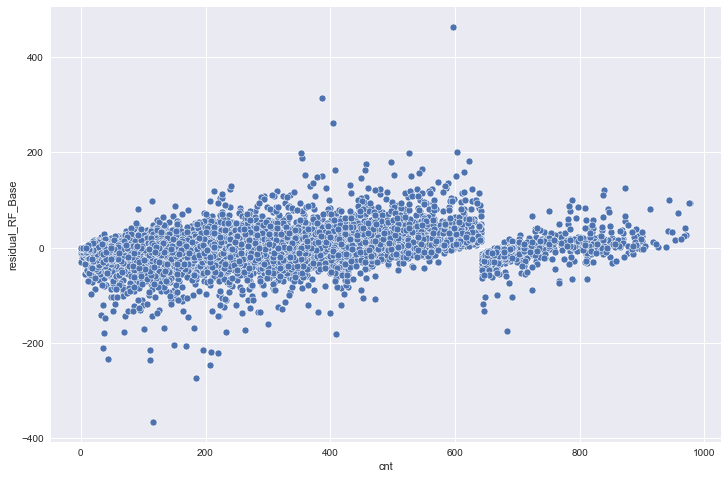

In [12]:
y_predict_RF_Base=pipe_RF_Base.predict(X)
df_ML['residual_RF_Base'] = y - y_predict_RF_Base
plt.figure(figsize=(12,8))
sns.scatterplot(x='cnt', y='residual_RF_Base', data=df_ML)
plt.show()

### XGBoost

In [13]:
pipe_XGB_Base.fit(X_train,y_train)
R2_train_XGB,MAE_train_XGB,MSE_train_XGB,RMSE_train_XGB,MedAE_train_XGB = Eva_Matrix(pipe_XGB_Base, X_train,y_train)
R2_test_XGB,MAE_test_XGB,MSE_test_XGB,RMSE_test_XGB,MedAE_test_XGB = Eva_Matrix(pipe_XGB_Base, X_test,y_test)
dataXGB = {
    'Training':[R2_train_XGB,MAE_train_XGB,MSE_train_XGB,RMSE_train_XGB,MedAE_train_XGB],
    'Testing':[R2_test_XGB,MAE_test_XGB,MSE_test_XGB,RMSE_test_XGB,MedAE_test_XGB]
}
pd.DataFrame(data=dataXGB, index=["R Squared", "MAE", "MSE", "RMSE","MedAE"])

,Training,Testing
R Squared,97.563629,94.987489
MAE,18.579046,26.070419
MSE,799.378196,1662.347040
RMSE,28.273277,40.771890
MedAE,11.640644,15.494263


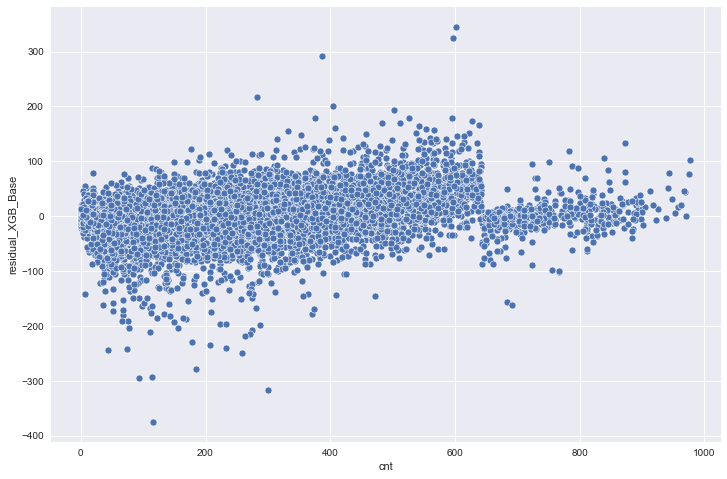

In [14]:
y_predict_XGB_Base=pipe_XGB_Base.predict(X)
df_ML['residual_XGB_Base'] = y - y_predict_XGB_Base
plt.figure(figsize=(12,8))
plt.style.use('seaborn')
sns.scatterplot(x='cnt', y='residual_XGB_Base', data=df_ML)
plt.show()

## Hyper Parameter Tuning

### RandomForest Bayes

In [15]:
param_RF = {
     'algo__n_estimators' : np.arange(100,8000,10),
     'algo__max_features': [None, 'auto', 'sqrt'],
     'algo__max_depth':    np.arange(1, 101, 5),
     'algo__min_samples_split' : np.arange(2, 8, 2),
     'algo__min_samples_leaf': np.arange(1, 10, 1),
}
RF_BS = BayesSearchCV(pipe_RF_Base, param_RF, cv = 3, n_jobs = -1, verbose=1)
RF_BS.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   49.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.0min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   41.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.3min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.0min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.1min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   18.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.8min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.7min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   58.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.0min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.9min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.0min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.0min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.3min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.0min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.1min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.1min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.3min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.4min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   39.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   31.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.0min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   28.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.7min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   51.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.3min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   58.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   26.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.8min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   45.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   40.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.8s finished


BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('prep',
                                         ColumnTransformer(transformers=[('numeric',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer())]),
                                                                          ['yr',
                                                                           'atemp',
                                                                           'hum',
                                                                           'windspeed']),
                                                                         ('categorical',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(

In [16]:
RF_BS.best_params_

OrderedDict([('algo__max_depth', 76),
             ('algo__max_features', 'auto'),
             ('algo__min_samples_leaf', 2),
             ('algo__min_samples_split', 2),
             ('algo__n_estimators', 6800)])

In [17]:
RF_BS = RF_BS.best_estimator_
R2_train_RF_BS,MAE_train_RF_BS,MSE_train_RF_BS,RMSE_train_RF_BS, MedAE_train_RF_BS = Eva_Matrix(RF_BS, X_train,y_train)
R2_test_RF_BS,MAE_test_RF_BS,MSE_test_RF_BS,RMSE_test_RF_BS,MedAE_test_RF_BS = Eva_Matrix(RF_BS, X_test,y_test)
dataRF_BS = {
    'Training':[R2_train_RF_BS,MAE_train_RF_BS,MSE_train_RF_BS,RMSE_train_RF_BS, MedAE_train_RF_BS],
    'Testing':[R2_test_RF_BS,MAE_test_RF_BS,MSE_test_RF_BS,RMSE_test_RF_BS, MedAE_test_RF_BS]
}
pd.DataFrame(data=dataRF_BS, index=["R Squared", "MAE", "MSE", "RMSE", "MedAE"])

,Training,Testing
R Squared,98.654477,95.029671
MAE,12.631126,25.373437
MSE,441.468803,1648.357991
RMSE,21.011159,40.599975
MedAE,7.028433,14.906992


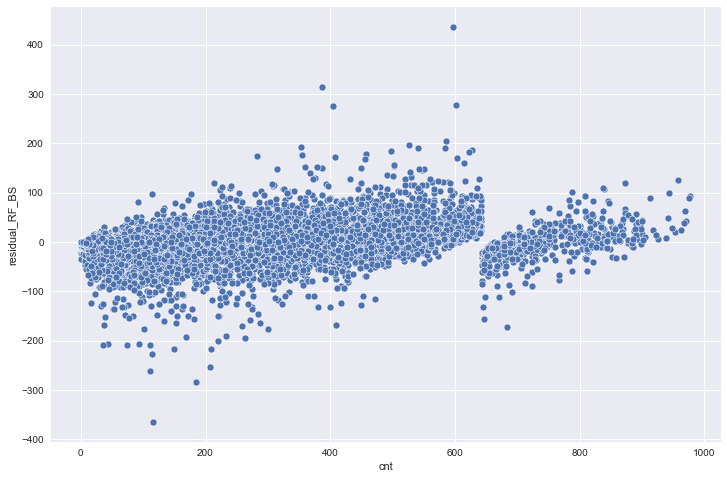

In [18]:
y_predict_RF_BS=RF_BS.predict(X)
df_ML['residual_RF_BS'] = y - y_predict_RF_BS
plt.figure(figsize=(12,8))
sns.scatterplot(x='cnt', y='residual_RF_BS', data=df_ML)
plt.show()

### RandomForest Random

In [19]:
param_RF1 = {
     'algo__n_estimators' : np.arange(100,8000,10),
     'algo__max_features': [None, 'auto', 'sqrt'],
     'algo__max_depth':    np.arange(1, 50, 5),
     'algo__min_samples_split' : np.arange(2, 8, 2),
     'algo__min_samples_leaf': np.arange(1, 10, 1),
}
RF_RS = RandomizedSearchCV(pipe_RF_Base, param_RF1, cv = 3, n_jobs = -1, verbose=1)
RF_RS.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.4min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer())]),
                                                                               ['yr',
                                                                                'atemp',
                                                                                'hum',
                                                                                'windspeed']),
                                                                              ('categorical',
                                                                               Pipeline(steps=[('imputer',
                                                  

In [20]:
RF_RS.best_params_

{'algo__n_estimators': 6170,
 'algo__min_samples_split': 2,
 'algo__min_samples_leaf': 1,
 'algo__max_features': 'auto',
 'algo__max_depth': 26}

In [21]:
RF_RS = RF_RS.best_estimator_
R2_train_RF_RS,MAE_train_RF_RS,MSE_train_RF_RS,RMSE_train_RF_RS,MedAE_train_RF_RS = Eva_Matrix(RF_RS, X_train,y_train)
R2_test_RF_RS,MAE_test_RF_RS,MSE_test_RF_RS,RMSE_test_RF_RS,MedAE_test_RF_RS = Eva_Matrix(RF_RS, X_test,y_test)
dataRF_RS = {
    'Training':[R2_train_RF_RS,MAE_train_RF_RS,MSE_train_RF_RS,RMSE_train_RF_RS,MedAE_train_RF_RS],
    'Testing':[R2_test_RF_RS,MAE_test_RF_RS,MSE_test_RF_RS,RMSE_test_RF_RS,MedAE_test_RF_RS]
}
pd.DataFrame(data=dataRF_RS, index=["R Squared", "MAE", "MSE", "RMSE", "MedAE"])

,Training,Testing
R Squared,99.335235,94.997472
MAE,9.184778,25.494080
MSE,218.110570,1659.036404
RMSE,14.768567,40.731271
MedAE,5.307293,14.841653


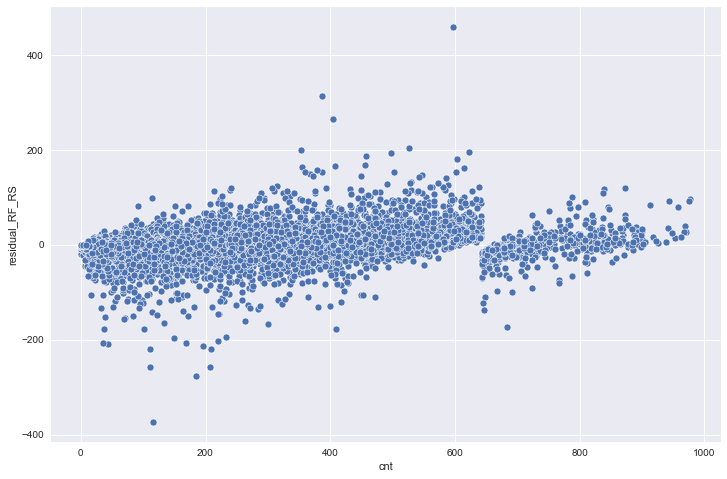

In [22]:
y_predict_RF_RS = RF_RS.predict(X)
df_ML['residual_RF_RS'] = y - y_predict_RF_RS
plt.figure(figsize=(12,8))
sns.scatterplot(x='cnt', y='residual_RF_RS', data=df_ML)
plt.show()

### DecisionTree Bayes

In [23]:
param_DT = {
     'algo__max_features': [None, 'auto'],
     'algo__max_depth':    np.arange(1, 101, 2),
     'algo__min_samples_split' : np.arange(1,21,1)*2,
     'algo__min_samples_leaf': np.arange(1,21,1),
}
DT_BS = BayesSearchCV(pipe_DT_Base, param_DT, cv = 3, n_jobs = -1, verbose=1)
DT_BS.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('prep',
                                         ColumnTransformer(transformers=[('numeric',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer())]),
                                                                          ['yr',
                                                                           'atemp',
                                                                           'hum',
                                                                           'windspeed']),
                                                                         ('categorical',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(

In [24]:
DT_BS.best_params_

OrderedDict([('algo__max_depth', 49),
             ('algo__max_features', 'auto'),
             ('algo__min_samples_leaf', 1),
             ('algo__min_samples_split', 16)])

In [25]:
DT_BS = DT_BS.best_estimator_
R2_train_DT_BS,MAE_train_DT_BS,MSE_train_DT_BS,RMSE_train_DT_BS,MedAE_train_DT_BS = Eva_Matrix(DT_BS, X_train,y_train)
R2_test_DT_BS,MAE_test_DT_BS,MSE_test_DT_BS,RMSE_test_DT_BS,MedAE_test_DT_BS = Eva_Matrix(DT_BS, X_test,y_test)
dataDT_BS = {
    'Training':[R2_train_DT_BS,MAE_train_DT_BS,MSE_train_DT_BS,RMSE_train_DT_BS,MedAE_train_DT_BS],
    'Testing':[R2_test_DT_BS,MAE_test_DT_BS,MSE_test_DT_BS,RMSE_test_DT_BS,MedAE_test_DT_BS]
}
pd.DataFrame(data=dataDT_BS, index=["R Squared", "MAE", "MSE", "RMSE", "MedAE"])

,Training,Testing
R Squared,96.810378,92.233244
MAE,19.533757,31.268196
MSE,1046.521142,2575.763885
RMSE,32.349979,50.751984
MedAE,10.750000,17.250000


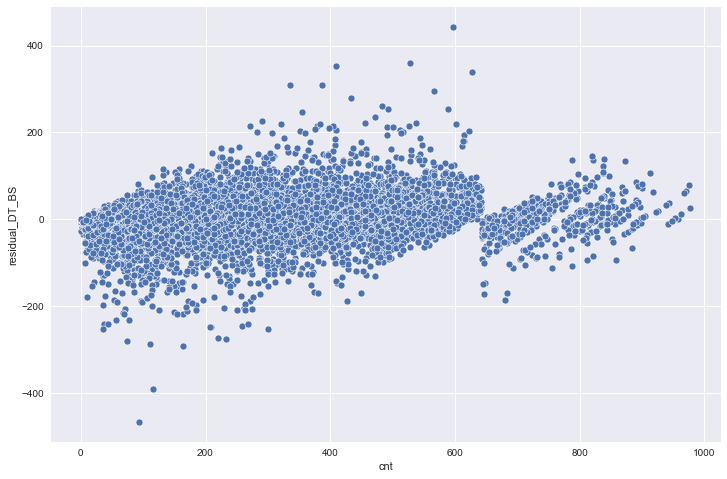

In [26]:
y_predict_DT_BS=DT_BS.predict(X)
df_ML['residual_DT_BS'] = y - y_predict_DT_BS
plt.figure(figsize=(12,8))
sns.scatterplot(x='cnt', y='residual_DT_BS', data=df_ML)
plt.show()

### DecisionTree Grid

In [27]:
param_DT1 = {
     'algo__max_features': [None, 'auto'],
     'algo__max_depth':    np.arange(1, 101, 2),
     'algo__min_samples_split' : np.arange(1,21,1)*2,
     'algo__min_samples_leaf': np.arange(1,21,1),
}
DT_GS = GridSearchCV(pipe_DT_Base, param_DT1, cv = 3, n_jobs = -1, verbose=1)
DT_GS.fit(X_train, y_train)

Fitting 3 folds for each of 40000 candidates, totalling 120000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   32.3s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done 4828 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 6328 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 8028 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 9928 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 12028 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 14328 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 16828 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 19528 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 22428 tasks 

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['yr',
                                                                          'atemp',
                                                                          'hum',
                                                                          'windspeed']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='mo

In [28]:
DT_GS.best_params_

{'algo__max_depth': 15,
 'algo__max_features': None,
 'algo__min_samples_leaf': 2,
 'algo__min_samples_split': 12}

In [29]:
DT_GS = DT_GS.best_estimator_
R2_train_DT_GS,MAE_train_DT_GS,MSE_train_DT_GS,RMSE_train_DT_GS,MedAE_train_DT_GS = Eva_Matrix(DT_GS, X_train,y_train)
R2_test_DT_GS,MAE_test_DT_GS,MSE_test_DT_GS,RMSE_test_DT_GS,MedAE_test_DT_GS = Eva_Matrix(DT_GS, X_test,y_test)
dataDT_GS = {
    'Training':[R2_train_DT_GS,MAE_train_DT_GS,MSE_train_DT_GS,RMSE_train_DT_GS,MedAE_train_DT_GS],
    'Testing':[R2_test_DT_GS,MAE_test_DT_GS,MSE_test_DT_GS,RMSE_test_DT_GS,MedAE_test_DT_GS]
}
pd.DataFrame(data=dataDT_GS, index=["R Squared", "MAE", "MSE", "RMSE","MedAE"])

,Training,Testing
R Squared,96.821260,92.081840
MAE,19.923386,31.551836
MSE,1042.950694,2625.975484
RMSE,32.294747,51.244273
MedAE,11.142857,17.500000


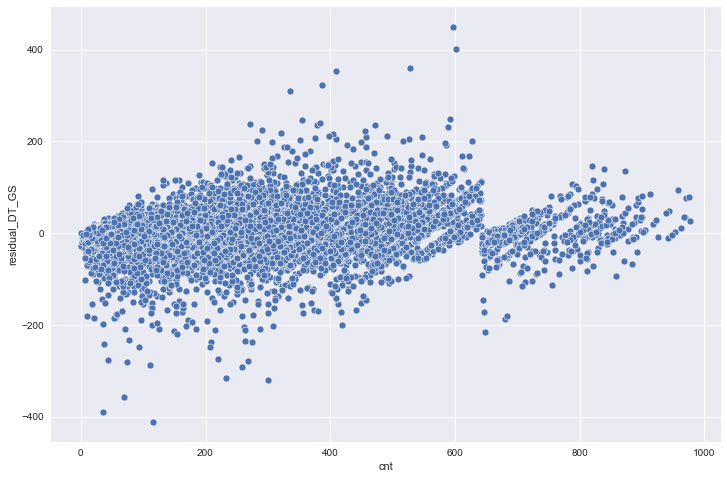

In [30]:
y_predict_DT_GS=DT_GS.predict(X)
df_ML['residual_DT_GS'] = y - y_predict_DT_GS
plt.figure(figsize=(12,8))
sns.scatterplot(x='cnt', y='residual_DT_GS', data=df_ML)
plt.show()

### DecisionTree Grid2

In [31]:
param_DT2 = {
    'algo__criterion' : ['mae'],
    'algo__max_features': [None],
    'algo__max_depth': [17],
    'algo__min_samples_split' : [16],
    'algo__min_samples_leaf': [2],
}
DT_GS2 = GridSearchCV(pipe_DT_Base, param_DT2, cv = 3, n_jobs = -1, verbose=1)
DT_GS2.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.1s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer())]),
                                                                         ['yr',
                                                                          'atemp',
                                                                          'hum',
                                                                          'windspeed']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='mo

In [32]:
DT_GS2.best_params_

{'algo__criterion': 'mae',
 'algo__max_depth': 17,
 'algo__max_features': None,
 'algo__min_samples_leaf': 2,
 'algo__min_samples_split': 16}

In [33]:
DT_GS2 = DT_GS2.best_estimator_
R2_train_DT_GS2,MAE_train_DT_GS2,MSE_train_DT_GS2,RMSE_train_DT_GS2,MedAE_train_DT_GS2 = Eva_Matrix(DT_GS2, X_train,y_train)
R2_test_DT_GS2,MAE_test_DT_GS2,MSE_test_DT_GS2,RMSE_test_DT_GS2,MedAE_test_DT_GS2 = Eva_Matrix(DT_GS2, X_test,y_test)
dataDT_GS2 = {
    'Training':[R2_train_DT_GS2,MAE_train_DT_GS2,MSE_train_DT_GS2,RMSE_train_DT_GS2,MedAE_train_DT_GS2],
    'Testing':[R2_test_DT_GS2,MAE_test_DT_GS2,MSE_test_DT_GS2,RMSE_test_DT_GS2,MedAE_test_DT_GS2]
}
pd.DataFrame(data=dataDT_GS2, index=["R Squared", "MAE", "MSE", "RMSE","MedAE"])

,Training,Testing
R Squared,95.728153,91.192706
MAE,19.960488,32.342923
MSE,1401.601235,2920.847411
RMSE,37.437965,54.044865
MedAE,8.500000,18.000000


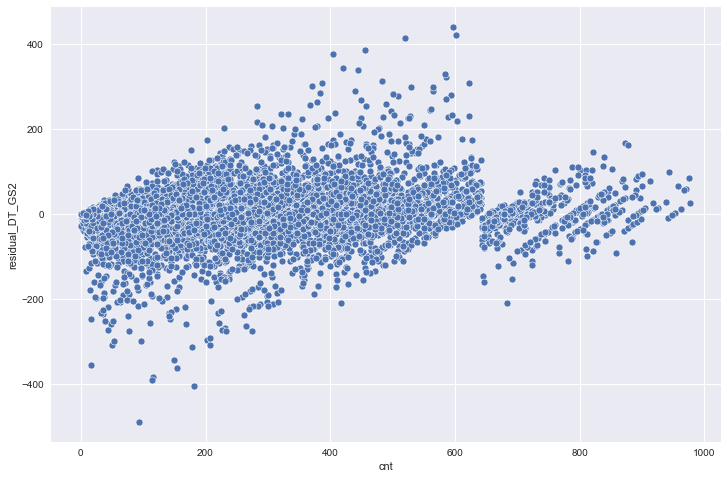

In [34]:
y_predict_DT_GS2=DT_GS2.predict(X)
df_ML['residual_DT_GS2'] = y - y_predict_DT_GS2
plt.figure(figsize=(12,8))
sns.scatterplot(x='cnt', y='residual_DT_GS2', data=df_ML)
plt.show()

### XGBoost Random

In [35]:
param_XGB = {
    'algo__n_estimators' : np.arange(100, 8000, 100),
    'algo__learning_rate' : [None, 0.1, 0.3, 0.5, 0.8, 1],
    'algo__max_depth' : np.arange(1, 50, 5),    

}
XGB_RS = RandomizedSearchCV(pipe_XGB_Base, param_XGB, cv = 3, n_jobs = -1, verbose=1)
XGB_RS.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.0min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('prep',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer())]),
                                                                               ['yr',
                                                                                'atemp',
                                                                                'hum',
                                                                                'windspeed']),
                                                                              ('categorical',
                                                                               Pipeline(steps=[('imputer',
                                                  

In [36]:
XGB_RS.best_params_

{'algo__n_estimators': 2300, 'algo__max_depth': 31, 'algo__learning_rate': 0.3}

In [37]:
XGB_RS = XGB_RS.best_estimator_
R2_train_XGB_RS,MAE_train_XGB_RS,MSE_train_XGB_RS,RMSE_train_XGB_RS,MedAE_train_XGB_RS = Eva_Matrix(XGB_RS, X_train,y_train)
R2_test_XGB_RS,MAE_test_XGB_RS,MSE_test_XGB_RS,RMSE_test_XGB_RS,MedAE_test_XGB_RS = Eva_Matrix(XGB_RS, X_test,y_test)
dataXGB_RS = {
    'Training':[R2_train_XGB_RS,MAE_train_XGB_RS,MSE_train_XGB_RS,RMSE_train_XGB_RS,MedAE_train_XGB_RS],
    'Testing':[R2_test_XGB_RS,MAE_test_XGB_RS,MSE_test_XGB_RS,RMSE_test_XGB_RS,MedAE_test_XGB_RS]
}
pd.DataFrame(data=dataXGB_RS, index=["R Squared", "MAE", "MSE", "RMSE","MedAE"])

,Training,Testing
R Squared,99.999884,94.824871
MAE,0.003417,25.883868
MSE,0.037901,1716.277645
RMSE,0.194683,41.427981
MedAE,0.000320,14.959915


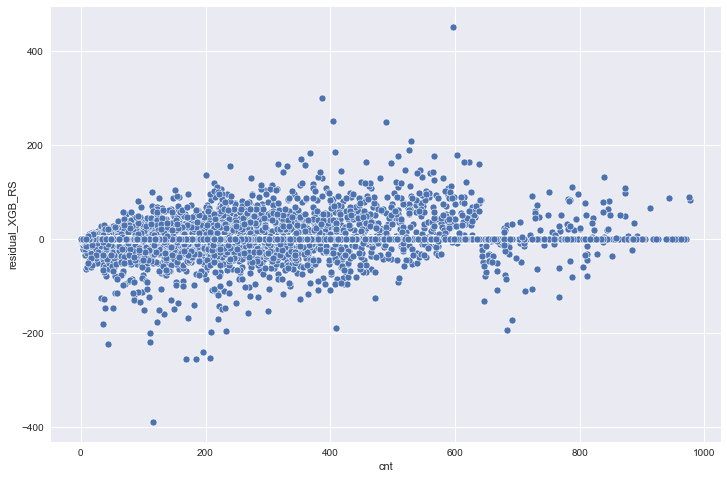

In [38]:
y_predict_XGB_RS=XGB_RS.predict(X)
df_ML['residual_XGB_RS'] = y - y_predict_XGB_RS
plt.figure(figsize=(12,8))
plt.style.use('seaborn')
sns.scatterplot(x='cnt', y='residual_XGB_RS', data=df_ML)
plt.show()

### XGBoost Bayes

In [39]:
param_XGB1 = {
    'algo__n_estimators' : np.arange(100, 8000, 100),
    'algo__learning_rate' : [None, 0.1, 0.3, 0.5, 0.8, 1],
    'algo__max_depth' : np.arange(1, 50, 5),
    
}
XGB_BS = BayesSearchCV(pipe_XGB_Base, param_XGB1, cv = 3, n_jobs = -1, verbose=1)
XGB_BS.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   40.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   43.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   20.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   21.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   27.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   23.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   25.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   22.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   10.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   55.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   24.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    8.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   15.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   13.0s finished


BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('prep',
                                         ColumnTransformer(transformers=[('numeric',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer())]),
                                                                          ['yr',
                                                                           'atemp',
                                                                           'hum',
                                                                           'windspeed']),
                                                                         ('categorical',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(

In [40]:
XGB_BS.best_params_

OrderedDict([('algo__learning_rate', 0.1),
             ('algo__max_depth', 6),
             ('algo__n_estimators', 1600)])

In [41]:
XGB_BS = XGB_BS.best_estimator_
R2_train_XGB_BS,MAE_train_XGB_BS,MSE_train_XGB_BS,RMSE_train_XGB_BS,MedAE_train_XGB_BS = Eva_Matrix(XGB_BS, X_train,y_train)
R2_test_XGB_BS,MAE_test_XGB_BS,MSE_test_XGB_BS,RMSE_test_XGB_BS,MedAE_test_XGB_BS = Eva_Matrix(XGB_BS, X_test,y_test)
dataXGB_BS = {
    'Training':[R2_train_XGB_BS,MAE_train_XGB_BS,MSE_train_XGB_BS,RMSE_train_XGB_BS,MedAE_train_XGB_BS],
    'Testing':[R2_test_XGB_BS,MAE_test_XGB_BS,MSE_test_XGB_BS,RMSE_test_XGB_BS,MedAE_test_XGB_BS]
}
pd.DataFrame(data=dataXGB_BS, index=["R Squared", "MAE", "MSE", "RMSE","MedAE"])

,Training,Testing
R Squared,99.412637,95.553821
MAE,8.976813,24.242375
MSE,192.715037,1474.529058
RMSE,13.882184,38.399597
MedAE,5.447159,14.732788


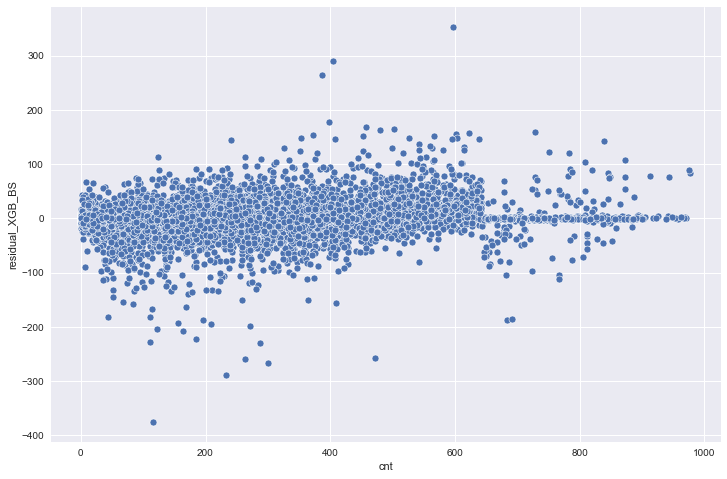

In [42]:
y_predict_XGB_BS=XGB_BS.predict(X)
df_ML['residual_XGB_BS'] = y - y_predict_XGB_BS
plt.figure(figsize=(12,8))
plt.style.use('seaborn')
sns.scatterplot(x='cnt', y='residual_XGB_BS', data=df_ML)
plt.show()

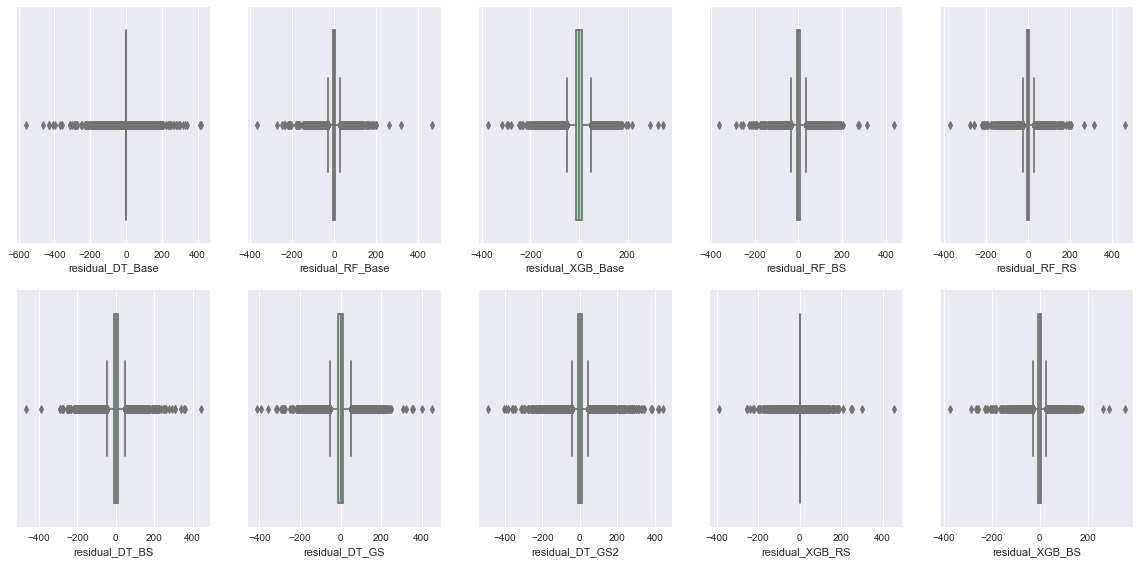

In [43]:
# Outliers Residual
df_describe = df_ML[['residual_DT_Base','residual_RF_Base','residual_XGB_Base','residual_RF_BS','residual_RF_RS','residual_DT_BS','residual_DT_GS','residual_DT_GS2','residual_XGB_RS','residual_XGB_BS']]
plt.figure(figsize =(20, 20))
x = 1 

for column in df_describe.columns:
    plt.subplot(4,5,x)
    sns.boxplot(x=df_describe[column], palette='rainbow')
    x+=1
plt.tight_layout
plt.show()

In [44]:
# Outliers Residual by Tabular
Desc_outliers = []

for i in df_ML[['residual_DT_Base','residual_RF_Base','residual_XGB_Base','residual_RF_BS','residual_RF_RS','residual_DT_BS','residual_DT_GS','residual_DT_GS2','residual_XGB_RS','residual_XGB_BS']]:
    Q1 = df_ML.describe()[i]['25%']
    Q3 = df_ML.describe()[i]['75%']
    IQR = Q3 - Q1
    upper_fence = Q3 + (1.5*IQR)
    lower_fence = Q1 - (1.5*IQR)
    hitung = 0
    
    for j in df_ML[i]:
        if (j < lower_fence) | (j > upper_fence) :
            hitung+=1
    Desc_outliers.append([
        i,
        hitung
    ])
            
# upper_fence, lower_fence
pd.DataFrame(Desc_outliers, columns=[
    "Data Features",
    "Number of Outliers"
])


,Data Features,Number of Outliers
0,residual_DT_Base,4225
1,residual_RF_Base,2398
2,residual_XGB_Base,1580
3,residual_RF_BS,2276
4,residual_RF_RS,2386
5,residual_DT_BS,2185
6,residual_DT_GS,2153
7,residual_DT_GS2,2922
8,residual_XGB_RS,4697
9,residual_XGB_BS,2073


## Compare

In [45]:
datacom = {
    'Base DecisionTree' : [R2_test_DT,MAE_test_DT,MSE_test_DT,RMSE_test_DT,MedAE_test_DT,df_ML[df_ML['residual_DT_Base']<=0]['residual_DT_Base'].count()/df_ML['residual_DT_Base'].count()],
    'Base RandomForest' : [R2_test_RF,MAE_test_RF,MSE_test_RF,RMSE_test_RF,MedAE_test_RF,df_ML[df_ML['residual_RF_Base']<=0]['residual_RF_Base'].count()/df_ML['residual_RF_Base'].count()],
    'Base XGBoost' : [R2_test_XGB,MAE_test_XGB,MSE_test_XGB,RMSE_test_XGB,MedAE_test_XGB,df_ML[df_ML['residual_XGB_Base']<=0]['residual_XGB_Base'].count()/df_ML['residual_XGB_Base'].count()],
    'RandomForest Tuned Bayes' : [R2_test_RF_BS,MAE_test_RF_BS,MSE_test_RF_BS,RMSE_test_RF_BS,MedAE_test_RF_BS,df_ML[df_ML['residual_RF_BS']<=0]['residual_RF_BS'].count()/df_ML['residual_RF_BS'].count()],
    'RandomForest Tuned Random' : [R2_test_RF_RS,MAE_test_RF_RS,MSE_test_RF_RS,RMSE_test_RF_RS,MedAE_test_RF_RS,df_ML[df_ML['residual_RF_RS']<=0]['residual_RF_RS'].count()/df_ML['residual_RF_RS'].count()],
    'DecisionTree Tuned Bayes' : [R2_test_DT_BS,MAE_test_DT_BS,MSE_test_DT_BS,RMSE_test_DT_BS,MedAE_test_DT_BS,df_ML[df_ML['residual_DT_BS']<=0]['residual_DT_BS'].count()/df_ML['residual_DT_BS'].count()],
    'DecisionTree Tuned Grid 1' : [R2_test_DT_GS,MAE_test_DT_GS,MSE_test_DT_GS,RMSE_test_DT_GS,MedAE_test_DT_GS,df_ML[df_ML['residual_DT_GS']<=0]['residual_DT_GS'].count()/df_ML['residual_DT_GS'].count()],
    'DecisionTree Tuned Grid 2' : [R2_test_DT_GS2,MAE_test_DT_GS2,MSE_test_DT_GS2,RMSE_test_DT_GS2,MedAE_test_DT_GS2,df_ML[df_ML['residual_DT_GS2']<=0]['residual_DT_GS2'].count()/df_ML['residual_DT_GS2'].count()],
    'XGBoost Tuned Random' : [R2_test_XGB_RS,MAE_test_XGB_RS,MSE_test_XGB_RS,RMSE_test_XGB_RS,MedAE_test_XGB_RS,df_ML[df_ML['residual_XGB_RS']<=0]['residual_XGB_RS'].count()/df_ML['residual_XGB_RS'].count()],
    'XGBoost Tuned Bayes' : [R2_test_XGB_BS,MAE_test_XGB_BS,MSE_test_XGB_BS,RMSE_test_XGB_BS,MedAE_test_XGB_BS,df_ML[df_ML['residual_XGB_BS']<=0]['residual_XGB_BS'].count()/df_ML['residual_XGB_BS'].count()]
}
compare = pd.DataFrame(data=datacom, index=["R Squared", "MAE", "MSE", "RMSE","MedAE", "Residual_Negative"]).T
print('Evaluation Matrix Comparison')
compare.reset_index(inplace=True)
compare#.sort_values('Residual_Negative', ascending=False)


Evaluation Matrix Comparison


,index,R Squared,MAE,MSE,RMSE,MedAE,Residual_Negative
0,Base DecisionTree,90.023868,34.598964,3308.480380,57.519391,19.000000,0.878532
1,Base RandomForest,94.908314,25.702521,1688.604542,41.092634,14.980000,0.530468
2,Base XGBoost,94.987489,26.070419,1662.347040,40.771890,15.494263,0.504172
3,RandomForest Tuned Bayes,95.029671,25.373437,1648.357991,40.599975,14.906992,0.527246
4,RandomForest Tuned Random,94.997472,25.494080,1659.036404,40.731271,14.841653,0.529547
5,DecisionTree Tuned Bayes,92.233244,31.268196,2575.763885,50.751984,17.250000,0.514471
6,DecisionTree Tuned Grid 1,92.081840,31.551836,2625.975484,51.244273,17.500000,0.511997
7,DecisionTree Tuned Grid 2,91.192706,32.342923,2920.847411,54.044865,18.000000,0.543472
8,XGBoost Tuned Random,94.824871,25.883868,1716.277645,41.427981,14.959915,0.538351
9,XGBoost Tuned Bayes,95.553821,24.242375,1474.529058,38.399597,14.732788,0.501582


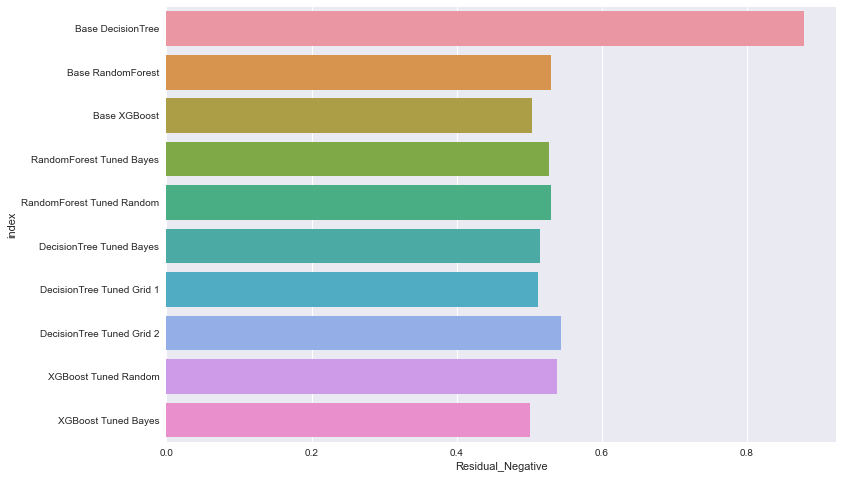

In [46]:
plt.figure(figsize=(12,8))
sns.barplot('Residual_Negative','index', data=compare)
plt.show()

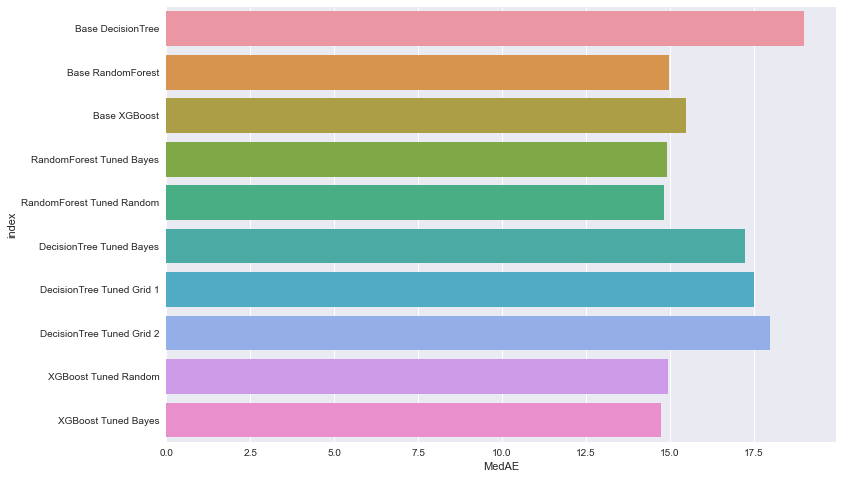

In [47]:
plt.figure(figsize=(12,8))
sns.barplot('MedAE','index', data=compare)
plt.show()

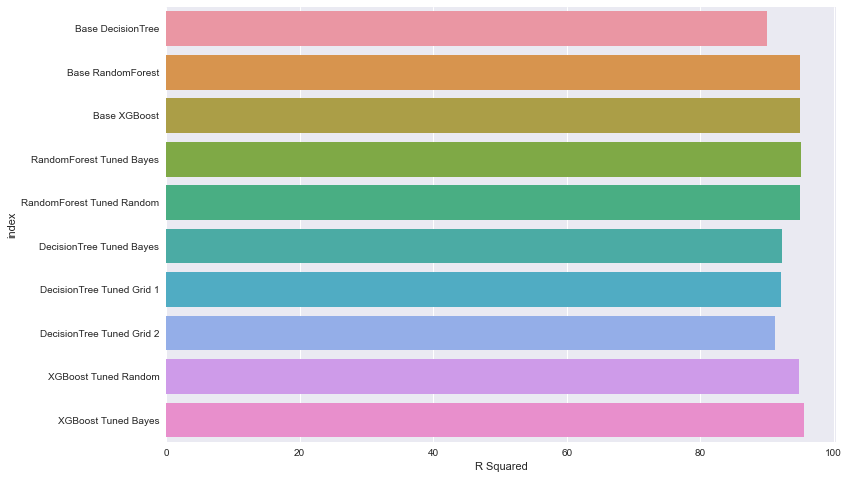

In [48]:
plt.figure(figsize=(12,8))
sns.barplot('R Squared','index', data=compare)
plt.show()

## Insight Machine Learning
Based on the Evaluation Matrix above, discovered that 5 Machine Learning Models that meet the criteria for Bike Sharing Prediction. With a scoring basis of R-Squared, M(ed)AE, and Residual Negative
- `Base DecisionTree` have the best Residual Negative score, but it's Overfitting. 
- `DecisionTree Tuned Grid 2` have the 2nd best Residual Negative score right after `Base DecisionTree`, but it's MedAE & R-Squared are not good enough.
- `Base RandomForest`, `RandomForest Tuned Bayes` and `RandomForest Tuned Random` have similar Evaluation Matrix score.

## Conclusion Machine Learning
Best model that we choose is **RandomForest Tuned Random**, because it’s R-Squared is 94.99, it’s MedAE is lower than the average of all MedAE and Residual Negative is 52.95%.


## Model Simulation
From Capital-Bikeshare data, bike rent fee is $\$$ 2 per 30 minute (or $\$$ 4 per hour).
- Assume from $\$$ 4, $\$$ 2 allocated for maintenance cost per bike.
- Assume previously the company used conventional method of predicting bike demand : 
    - By taking average or
    - Q3 from the previous month to predict the bike-demand.

So if 
- `y_pred < y_true` then we might lost customer (lost $\$$ 4 times y_true - y_pred)

whereas if
- `y_pred > y_true` then we might lost $\$$ 2 for maintenance for each unused bikes

Based on these assumptions, we want to compare the monthly cost by machine learning model and conventional method

In [49]:
## Splitting Data for Simulation
## Data Test for Simulation using Data from Dataset Bike Sharing specifically Desember 2012
test=df[(df['mnth']==12)&(df['yr']==2012)]
train=df[~((df['mnth']==12)&(df['yr']==2012))]
test.shape, train.shape

((742, 17), (16637, 17))

### Data Preparation

In [50]:
df_ML2 = train[['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'atemp', 'hum', 'windspeed', 'cnt','event']]
df_ML2.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt,event
instant,,,,,,,,,,,,,
1,1,2011,1,0,0,6,0,1,3.0,81.0,0.0,16,0
2,1,2011,1,1,0,6,0,1,2.0,80.0,0.0,40,0
3,1,2011,1,2,0,6,0,1,2.0,80.0,0.0,32,0
4,1,2011,1,3,0,6,0,1,3.0,75.0,0.0,13,0
5,1,2011,1,4,0,6,0,1,3.0,75.0,0.0,1,0


In [51]:
X2 = df_ML2.drop(columns='cnt')
y2 = df_ML2['cnt']
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=36)

### DecisionTree

In [52]:
DT=DecisionTreeRegressor(random_state=36)
DT.fit(X2_train, y2_train)

DecisionTreeRegressor(random_state=36)

### RandomForest

In [53]:
RF=RandomForestRegressor(random_state=36)
RF.fit(X2_train, y2_train)

RandomForestRegressor(random_state=36)

### XGBoost

In [54]:
XGB=XGBRegressor(random_state=36)
XGB.fit(X2_train, y2_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=36,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### DecisionTree Bayes

In [55]:
    DT1=DecisionTreeRegressor(random_state=36,max_depth = 49, max_features = 'auto', min_samples_leaf = 1, min_samples_split = 16)
DT1.fit(X2_train, y2_train)

DecisionTreeRegressor(max_depth=49, max_features='auto', min_samples_split=16,
                      random_state=36)

### DecisionTree Grid 1

In [56]:
DT2=DecisionTreeRegressor(random_state=36, max_depth = 15, max_features = None, min_samples_leaf = 2, min_samples_split = 12)
DT2.fit(X2_train, y2_train)

DecisionTreeRegressor(max_depth=15, min_samples_leaf=2, min_samples_split=12,
                      random_state=36)

### DecisionTree Grid 2

In [57]:
DT3=DecisionTreeRegressor(random_state=36, criterion = 'mae', max_depth = 17, max_features = None, min_samples_leaf = 2, min_samples_split = 16)
DT3.fit(X2_train, y2_train)

DecisionTreeRegressor(criterion='mae', max_depth=17, min_samples_leaf=2,
                      min_samples_split=16, random_state=36)

### RandomForest Bayes

In [58]:
RF1=RandomForestRegressor(random_state=36, max_depth = 76, max_features = 'auto', min_samples_leaf = 2, min_samples_split = 2, n_estimators = 6800)
RF1.fit(X2_train, y2_train)

RandomForestRegressor(max_depth=76, min_samples_leaf=2, n_estimators=6800,
                      random_state=36)

### RandomForest Randomized

In [59]:
RF2=RandomForestRegressor(random_state=36, n_estimators = 6170, min_samples_split = 2, min_samples_leaf = 1, max_features = 'auto', max_depth = 26)
RF2.fit(X2_train, y2_train)

RandomForestRegressor(max_depth=26, n_estimators=6170, random_state=36)

### XGBoost Randomized

In [60]:
XGB1=XGBRegressor(random_state=36, n_estimators=2300, max_depth=31, learning_rate=0.3)
XGB1.fit(X2_train, y2_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=31,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2300, n_jobs=12, num_parallel_tree=1, random_state=36,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### XGBoost Bayes

In [61]:
XGB2=XGBRegressor(random_state=36, n_estimators=1600, max_depth=6, learning_rate=0.1)
XGB2.fit(X2_train, y2_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1600, n_jobs=12, num_parallel_tree=1, random_state=36,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Model Predict

In [62]:
# test = test.drop(columns=['cnt','dteday','casual','registered','temp'])
test['predDT']=np.ceil(DT.predict(test[['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'atemp', 'hum', 'windspeed','event']]))
test['predRF']=np.ceil(RF.predict(test[['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'atemp', 'hum', 'windspeed','event']]))
test['predXGB']=np.ceil(XGB.predict(test[['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'atemp', 'hum', 'windspeed','event']]))
test['predDT_Bayes']=np.ceil(DT1.predict(test[['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'atemp', 'hum', 'windspeed','event']]))
test['predDT_Grid1']=np.ceil(DT2.predict(test[['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'atemp', 'hum', 'windspeed','event']]))
test['predDT_Grid2']=np.ceil(DT3.predict(test[['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'atemp', 'hum', 'windspeed','event']]))
test['predRF_Bayes']=np.ceil(RF1.predict(test[['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'atemp', 'hum', 'windspeed','event']]))
test['predRF_Random']=np.ceil(RF2.predict(test[['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'atemp', 'hum', 'windspeed','event']]))
test['predXGB_Random']=np.ceil(XGB1.predict(test[['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'atemp', 'hum', 'windspeed','event']]))
test['predXGB_Bayes']=np.ceil(XGB2.predict(test[['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'atemp', 'hum', 'windspeed','event']]))
test

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,event,predDT,predRF,predXGB,predDT_Bayes,predDT_Grid1,predDT_Grid2,predRF_Bayes,predRF_Random,predXGB_Random,predXGB_Bayes
instant,,,,,,,,,,,,,,,,,,,,,,,,,,,
16638,2012-12-01,4,2012,12,0,0,6,0,1,4.22,4.0,81.0,0.0,9,99,108,0,122.0,118.0,92.0,115.0,115.0,122.0,112.0,115.0,118.0,104.0
16639,2012-12-01,4,2012,12,1,0,6,0,1,4.22,4.0,81.0,0.0,5,64,69,0,76.0,101.0,67.0,113.0,113.0,75.0,96.0,97.0,58.0,86.0
16640,2012-12-01,4,2012,12,2,0,6,0,2,4.22,4.0,81.0,0.0,3,47,50,0,44.0,59.0,42.0,76.0,76.0,75.0,59.0,59.0,29.0,57.0
16641,2012-12-01,4,2012,12,3,0,6,0,2,4.22,2.0,81.0,9.0,1,14,15,0,18.0,17.0,-17.0,15.0,15.0,16.0,15.0,16.0,17.0,22.0
16642,2012-12-01,4,2012,12,4,0,6,0,1,4.22,3.0,81.0,6.0,0,5,5,0,12.0,10.0,-21.0,14.0,12.0,12.0,10.0,10.0,11.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17375,2012-12-31,1,2012,12,19,0,1,1,2,4.22,1.0,60.0,11.0,11,108,119,0,287.0,290.0,287.0,266.0,266.0,266.0,286.0,290.0,243.0,274.0
17376,2012-12-31,1,2012,12,20,0,1,1,2,4.22,1.0,60.0,11.0,8,81,89,0,136.0,202.0,179.0,139.0,139.0,254.0,197.0,202.0,185.0,180.0
17377,2012-12-31,1,2012,12,21,0,1,1,1,4.22,1.0,60.0,11.0,7,83,90,0,136.0,136.0,122.0,139.0,139.0,120.0,138.0,139.0,151.0,136.0


In [63]:
## Data Sampling for Conventional Method
sampling=train[(train['mnth']==11)&(train['yr']==2012)]
sampling

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,event
instant,,,,,,,,,,,,,,,,,
15920,2012-11-01,4,2012,11,0,0,4,1,1,8.92,8.0,57.0,6.0,8,52,60,0
15921,2012-11-01,4,2012,11,1,0,4,1,1,6.10,5.0,75.0,7.0,8,22,30,0
15922,2012-11-01,4,2012,11,2,0,4,1,1,7.04,6.0,66.0,9.0,10,10,20,0
15923,2012-11-01,4,2012,11,3,0,4,1,1,7.98,6.0,61.0,9.0,5,10,15,0
15924,2012-11-01,4,2012,11,4,0,4,1,2,7.98,7.0,66.0,7.0,2,8,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16633,2012-11-30,4,2012,11,19,0,5,1,1,7.04,7.0,66.0,0.0,18,359,377,0
16634,2012-11-30,4,2012,11,20,0,5,1,1,7.04,7.0,66.0,0.0,12,233,245,0
16635,2012-11-30,4,2012,11,21,0,5,1,1,6.10,5.0,75.0,6.0,14,169,183,0


In [64]:
test['predQ3']=0
for k in range(742):
    ind=test.iloc[k]['weekday']
    waktu=test.iloc[k]['hr']
    hari=sampling[sampling['weekday']==ind]
    q3=hari[hari['hr']==waktu]['cnt'].describe()['75%']
    test['predQ3'].iloc[k]=q3

In [65]:
test['predMean']=0
for k in range(742):
    ind=test.iloc[k]['weekday']
    waktu=test.iloc[k]['hr']
    hari=sampling[sampling['weekday']==ind]
    mean=hari[hari['hr']==waktu]['cnt'].describe()['mean']
    test['predMean'].iloc[k]=mean

In [66]:
test

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,event,predDT,predRF,predXGB,predDT_Bayes,predDT_Grid1,predDT_Grid2,predRF_Bayes,predRF_Random,predXGB_Random,predXGB_Bayes,predQ3,predMean
instant,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
16638,2012-12-01,4,2012,12,0,0,6,0,1,4.22,4.0,81.0,0.0,9,99,108,0,122.0,118.0,92.0,115.0,115.0,122.0,112.0,115.0,118.0,104.0,111.50,94.50
16639,2012-12-01,4,2012,12,1,0,6,0,1,4.22,4.0,81.0,0.0,5,64,69,0,76.0,101.0,67.0,113.0,113.0,75.0,96.0,97.0,58.0,86.0,87.50,68.00
16640,2012-12-01,4,2012,12,2,0,6,0,2,4.22,4.0,81.0,0.0,3,47,50,0,44.0,59.0,42.0,76.0,76.0,75.0,59.0,59.0,29.0,57.0,46.75,42.75
16641,2012-12-01,4,2012,12,3,0,6,0,2,4.22,2.0,81.0,9.0,1,14,15,0,18.0,17.0,-17.0,15.0,15.0,16.0,15.0,16.0,17.0,22.0,22.75,20.00
16642,2012-12-01,4,2012,12,4,0,6,0,1,4.22,3.0,81.0,6.0,0,5,5,0,12.0,10.0,-21.0,14.0,12.0,12.0,10.0,10.0,11.0,6.0,9.25,8.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17375,2012-12-31,1,2012,12,19,0,1,1,2,4.22,1.0,60.0,11.0,11,108,119,0,287.0,290.0,287.0,266.0,266.0,266.0,286.0,290.0,243.0,274.0,380.50,375.50
17376,2012-12-31,1,2012,12,20,0,1,1,2,4.22,1.0,60.0,11.0,8,81,89,0,136.0,202.0,179.0,139.0,139.0,254.0,197.0,202.0,185.0,180.0,283.75,270.25
17377,2012-12-31,1,2012,12,21,0,1,1,1,4.22,1.0,60.0,11.0,7,83,90,0,136.0,136.0,122.0,139.0,139.0,120.0,138.0,139.0,151.0,136.0,186.50,172.75


In [67]:
## Simulation
test['gap_predDT']=test['cnt']-test['predDT']
test['gap_predRF']=test['cnt']-test['predRF']
test['gap_predXGB']=test['cnt']-test['predXGB']
test['gap_predDT_Bayes']=test['cnt']-test['predDT_Bayes']
test['gap_predDT_Grid1']=test['cnt']-test['predDT_Grid1']
test['gap_predDT_Grid2']=test['cnt']-test['predDT_Grid2']
test['gap_predRF_Bayes']=test['cnt']-test['predRF_Bayes']
test['gap_predRF_Random']=test['cnt']-test['predRF_Random']
test['gap_predXGB_Random']=test['cnt']-test['predXGB_Random']
test['gap_predXGB_Bayes']=test['cnt']-test['predXGB_Bayes']
test['gap_predQ3']=test['cnt']-test['predQ3']
test['gap_predMean']=test['cnt']-test['predMean']
test['sales']=test['cnt']*4
test['cost_predDT']=test['gap_predDT'].apply(lambda x : abs(x*4) if x >= 0 else abs(x*2))
test['cost_predRF']=test['gap_predRF'].apply(lambda x : abs(x*4) if x >= 0 else abs(x*2))
test['cost_predXGB']=test['gap_predXGB'].apply(lambda x : abs(x*4) if x >= 0 else abs(x*2))
test['cost_predDT_Bayes']=test['gap_predDT_Bayes'].apply(lambda x : abs(x*4) if x >= 0 else abs(x*2))
test['cost_predDT_Grid1']=test['gap_predDT_Grid1'].apply(lambda x : abs(x*4) if x >= 0 else abs(x*2))
test['cost_predDT_Grid2']=test['gap_predDT_Grid2'].apply(lambda x : abs(x*4) if x >= 0 else abs(x*2))
test['cost_predRF_Bayes']=test['gap_predRF_Bayes'].apply(lambda x : abs(x*4) if x >= 0 else abs(x*2))
test['cost_predRF_Random']=test['gap_predRF_Random'].apply(lambda x : abs(x*4) if x >= 0 else abs(x*2))
test['cost_predXGB_Random']=test['gap_predXGB_Random'].apply(lambda x : abs(x*4) if x >= 0 else abs(x*2))
test['cost_predXGB_Bayes']=test['gap_predXGB_Bayes'].apply(lambda x : abs(x*4) if x >= 0 else abs(x*2))
test['cost_predQ3']=test['gap_predQ3'].apply(lambda x : abs(x*4) if x >= 0 else abs(x*2))
test['cost_predMean']=test['gap_predMean'].apply(lambda x : abs(x*4) if x >= 0 else abs(x*2))
test

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,event,predDT,predRF,predXGB,predDT_Bayes,predDT_Grid1,predDT_Grid2,predRF_Bayes,predRF_Random,predXGB_Random,predXGB_Bayes,predQ3,predMean,gap_predDT,gap_predRF,gap_predXGB,gap_predDT_Bayes,gap_predDT_Grid1,gap_predDT_Grid2,gap_predRF_Bayes,gap_predRF_Random,gap_predXGB_Random,gap_predXGB_Bayes,gap_predQ3,gap_predMean,sales,cost_predDT,cost_predRF,cost_predXGB,cost_predDT_Bayes,cost_predDT_Grid1,cost_predDT_Grid2,cost_predRF_Bayes,cost_predRF_Random,cost_predXGB_Random,cost_predXGB_Bayes,cost_predQ3,cost_predMean
instant,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
16638,2012-12-01,4,2012,12,0,0,6,0,1,4.22,4.0,81.0,0.0,9,99,108,0,122.0,118.0,92.0,115.0,115.0,122.0,112.0,115.0,118.0,104.0,111.50,94.50,-14.0,-10.0,16.0,-7.0,-7.0,-14.0,-4.0,-7.0,-10.0,4.0,-3.50,13.50,432,28.0,20.0,64.0,14.0,14.0,28.0,8.0,14.0,20.0,16.0,7.0,54.0
16639,2012-12-01,4,2012,12,1,0,6,0,1,4.22,4.0,81.0,0.0,5,64,69,0,76.0,101.0,67.0,113.0,113.0,75.0,96.0,97.0,58.0,86.0,87.50,68.00,-7.0,-32.0,2.0,-44.0,-44.0,-6.0,-27.0,-28.0,11.0,-17.0,-18.50,1.00,276,14.0,64.0,8.0,88.0,88.0,12.0,54.0,56.0,44.0,34.0,37.0,4.0
16640,2012-12-01,4,2012,12,2,0,6,0,2,4.22,4.0,81.0,0.0,3,47,50,0,44.0,59.0,42.0,76.0,76.0,75.0,59.0,59.0,29.0,57.0,46.75,42.75,6.0,-9.0,8.0,-26.0,-26.0,-25.0,-9.0,-9.0,21.0,-7.0,3.25,7.25,200,24.0,18.0,32.0,52.0,52.0,50.0,18.0,18.0,84.0,14.0,13.0,29.0
16641,2012-12-01,4,2012,12,3,0,6,0,2,4.22,2.0,81.0,9.0,1,14,15,0,18.0,17.0,-17.0,15.0,15.0,16.0,15.0,16.0,17.0,22.0,22.75,20.00,-3.0,-2.0,32.0,0.0,0.0,-1.0,0.0,-1.0,-2.0,-7.0,-7.75,-5.00,60,6.0,4.0,128.0,0.0,0.0,2.0,0.0,2.0,4.0,14.0,15.5,10.0
16642,2012-12-01,4,2012,12,4,0,6,0,1,4.22,3.0,81.0,6.0,0,5,5,0,12.0,10.0,-21.0,14.0,12.0,12.0,10.0,10.0,11.0,6.0,9.25,8.00,-7.0,-5.0,26.0,-9.0,-7.0,-7.0,-5.0,-5.0,-6.0,-1.0,-4.25,-3.00,20,14.0,10.0,104.0,18.0,14.0,14.0,10.0,10.0,12.0,2.0,8.5,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17375,2012-12-31,1,2012,12,19,0,1,1,2,4.22,1.0,60.0,11.0,11,108,119,0,287.0,290.0,287.0,266.0,266.0,266.0,286.0,290.0,243.0,274.0,380.50,375.50,-168.0,-171.0,-168.0,-147.0,-147.0,-147.0,-167.0,-171.0,-124.0,-155.0,-261.50,-256.50,476,336.0,342.0,336.0,294.0,294.0,294.0,334.0,342.0,248.0,310.0,523.0,513.0
17376,2012-12-31,1,2012,12,20,0,1,1,2,4.22,1.0,60.0,11.0,8,81,89,0,136.0,202.0,179.0,139.0,139.0,254.0,197.0,202.0,185.0,180.0,283.75,270.25,-47.0,-113.0,-90.0,-50.0,-50.0,-165.0,-108.0,-113.0,-96.0,-91.0,-194.75,-181.25,356,94.0,226.0,180.0,100.0,100.0,330.0,216.0,226.0,192.0,182.0,389.5,362.5
17377,2012-12-31,1,2012,12,21,0,1,1,1,4.22,1.0,60.0,11.0,7,83,90,0,136.0,136.0,122.0,139.0,139.0,120.0,138.0,139.0,151.0,136.0,186.50,172.75,-46.0,-46.0,-32.0,-49.0,-49.0,-30.0,-48.0,-49.0,-61.0,-46.0,-96.50,-82.75,360,92.0,92.0,64.0,98.0,98.0,60.0,96.0,98.0,122.0,92.0,193.0,165.5


In [68]:
print('Comparison of Actual Sales and Cost of each Method/Model')
test[['sales','cost_predDT','cost_predRF','cost_predXGB','cost_predDT_Bayes','cost_predDT_Grid1','cost_predDT_Grid2','cost_predRF_Bayes','cost_predRF_Random','cost_predXGB_Random','cost_predXGB_Bayes','cost_predQ3','cost_predMean']].sum()

Comparison of Actual Sales and Cost of each Method/Model


sales                  494852.000000
cost_predDT            127782.000000
cost_predRF             93356.000000
cost_predXGB            90902.000000
cost_predDT_Bayes      119728.000000
cost_predDT_Grid1      119176.000000
cost_predDT_Grid2      111080.000000
cost_predRF_Bayes       90514.000000
cost_predRF_Random      92460.000000
cost_predXGB_Random    108874.000000
cost_predXGB_Bayes      87686.000000
cost_predQ3            130795.000000
cost_predMean          123343.733333
dtype: float64

In [69]:
print('Percentage of Cost to Actual Sales')
test[['cost_predDT','cost_predRF','cost_predXGB','cost_predDT_Bayes','cost_predDT_Grid1','cost_predDT_Grid2','cost_predRF_Bayes','cost_predRF_Random','cost_predXGB_Random','cost_predXGB_Bayes','cost_predQ3','cost_predMean']].sum()/test['sales'].sum()*100

Percentage of Cost to Actual Sales


cost_predDT            25.822266
cost_predRF            18.865439
cost_predXGB           18.369533
cost_predDT_Bayes      24.194709
cost_predDT_Grid1      24.083160
cost_predDT_Grid2      22.447116
cost_predRF_Bayes      18.291125
cost_predRF_Random     18.684374
cost_predXGB_Random    22.001326
cost_predXGB_Bayes     17.719641
cost_predQ3            26.431135
cost_predMean          24.925378
dtype: float64

In [70]:
print('Difference between Machine Learning Model (DT) and Conventional Method')
print(f"{round(test['cost_predMean'].sum()/test['sales'].sum()*100-test['cost_predDT'].sum()/test['sales'].sum()*100,2)}% - {round(test['cost_predQ3'].sum()/test['sales'].sum()*100-test['cost_predDT'].sum()/test['sales'].sum()*100,2)}%")

Difference between Machine Learning Model (DT) and Conventional Method
-0.9% - 0.61%


In [71]:
print('Difference between Machine Learning Model (RF) and Conventional Method')
print(f"{round(test['cost_predMean'].sum()/test['sales'].sum()*100-test['cost_predRF'].sum()/test['sales'].sum()*100,2)}% - {round(test['cost_predQ3'].sum()/test['sales'].sum()*100-test['cost_predRF'].sum()/test['sales'].sum()*100,2)}%")

Difference between Machine Learning Model (RF) and Conventional Method
6.06% - 7.57%


In [72]:
print('Difference between Machine Learning Model (XGB) and Conventional Method')
print(f"{round(test['cost_predMean'].sum()/test['sales'].sum()*100-test['cost_predXGB'].sum()/test['sales'].sum()*100,2)}% - {round(test['cost_predQ3'].sum()/test['sales'].sum()*100-test['cost_predXGB'].sum()/test['sales'].sum()*100,2)}%")

Difference between Machine Learning Model (XGB) and Conventional Method
6.56% - 8.06%


In [73]:
print('Difference between Machine Learning Model (DT Bayes) and Conventional Method')
print(f"{round(test['cost_predMean'].sum()/test['sales'].sum()*100-test['cost_predDT_Bayes'].sum()/test['sales'].sum()*100,2)}% - {round(test['cost_predQ3'].sum()/test['sales'].sum()*100-test['cost_predDT_Bayes'].sum()/test['sales'].sum()*100,2)}%")

Difference between Machine Learning Model (DT Bayes) and Conventional Method
0.73% - 2.24%


In [74]:
print('Difference between Machine Learning Model (DT Grid 1) and Conventional Method')
print(f"{round(test['cost_predMean'].sum()/test['sales'].sum()*100-test['cost_predDT_Grid1'].sum()/test['sales'].sum()*100,2)}% - {round(test['cost_predQ3'].sum()/test['sales'].sum()*100-test['cost_predDT_Grid1'].sum()/test['sales'].sum()*100,2)}%")

Difference between Machine Learning Model (DT Grid 1) and Conventional Method
0.84% - 2.35%


In [75]:
print('Difference between Machine Learning Model (DT Grid 2) and Conventional Method')
print(f"{round(test['cost_predMean'].sum()/test['sales'].sum()*100-test['cost_predDT_Grid2'].sum()/test['sales'].sum()*100,2)}% - {round(test['cost_predQ3'].sum()/test['sales'].sum()*100-test['cost_predDT_Grid2'].sum()/test['sales'].sum()*100,2)}%")

Difference between Machine Learning Model (DT Grid 2) and Conventional Method
2.48% - 3.98%


In [76]:
print('Difference between Machine Learning Model (RF Bayes) and Conventional Method')
print(f"{round(test['cost_predMean'].sum()/test['sales'].sum()*100-test['cost_predRF_Bayes'].sum()/test['sales'].sum()*100,2)}% - {round(test['cost_predQ3'].sum()/test['sales'].sum()*100-test['cost_predRF_Bayes'].sum()/test['sales'].sum()*100,2)}%")

Difference between Machine Learning Model (RF Bayes) and Conventional Method
6.63% - 8.14%


In [77]:
print('Difference between Machine Learning Model (RF Random) and Conventional Method')
print(f"{round(test['cost_predMean'].sum()/test['sales'].sum()*100-test['cost_predRF_Random'].sum()/test['sales'].sum()*100,2)}% - {round(test['cost_predQ3'].sum()/test['sales'].sum()*100-test['cost_predRF_Random'].sum()/test['sales'].sum()*100,2)}%")

Difference between Machine Learning Model (RF Random) and Conventional Method
6.24% - 7.75%


In [78]:
print('Difference between Machine Learning Model (XGB Randomized) and Conventional Method')
print(f"{round(test['cost_predMean'].sum()/test['sales'].sum()*100-test['cost_predXGB_Random'].sum()/test['sales'].sum()*100,2)}% - {round(test['cost_predQ3'].sum()/test['sales'].sum()*100-test['cost_predXGB_Random'].sum()/test['sales'].sum()*100,2)}%")

Difference between Machine Learning Model (XGB Randomized) and Conventional Method
2.92% - 4.43%


In [79]:
print('Difference between Machine Learning Model (XGB Bayes) and Conventional Method')
print(f"{round(test['cost_predMean'].sum()/test['sales'].sum()*100-test['cost_predXGB_Bayes'].sum()/test['sales'].sum()*100,2)}% - {round(test['cost_predQ3'].sum()/test['sales'].sum()*100-test['cost_predXGB_Bayes'].sum()/test['sales'].sum()*100,2)}%")

Difference between Machine Learning Model (XGB Bayes) and Conventional Method
7.21% - 8.71%


In [80]:
simul=test[['cnt', 'predRF_Random', 'predQ3', 'predMean', 'gap_predRF_Random', 'gap_predQ3', 'gap_predMean', 'sales', 'cost_predRF_Random', 'cost_predQ3', 'cost_predMean']]
simul

,cnt,predRF_Random,predQ3,predMean,gap_predRF_Random,gap_predQ3,gap_predMean,sales,cost_predRF_Random,cost_predQ3,cost_predMean
instant,,,,,,,,,,,
16638,108,115.0,111.50,94.50,-7.0,-3.50,13.50,432,14.0,7.0,54.0
16639,69,97.0,87.50,68.00,-28.0,-18.50,1.00,276,56.0,37.0,4.0
16640,50,59.0,46.75,42.75,-9.0,3.25,7.25,200,18.0,13.0,29.0
16641,15,16.0,22.75,20.00,-1.0,-7.75,-5.00,60,2.0,15.5,10.0
16642,5,10.0,9.25,8.00,-5.0,-4.25,-3.00,20,10.0,8.5,6.0
...,...,...,...,...,...,...,...,...,...,...,...
17375,119,290.0,380.50,375.50,-171.0,-261.50,-256.50,476,342.0,523.0,513.0
17376,89,202.0,283.75,270.25,-113.0,-194.75,-181.25,356,226.0,389.5,362.5
17377,90,139.0,186.50,172.75,-49.0,-96.50,-82.75,360,98.0,193.0,165.5


## Simulation Conclusion with Machine Learning Model
Even though Machine Learning Model is not perfect yet, but this Model have lower 6%-8% per month Cost than conventional method. 

## Future Works
To conclude, We understand that Our Machine Learning Prediction on this Project  is not perfect. Because there’s several factors that can improve Our Model Prediction such as:
- Cost/Sales of the Bike Rent
- Duration of Bike Usage
- Distance of Bike Usage
- Numbers of Bike Station and their Specific Location

We can try to define our custom metric performance that has more related to our business goals as follows

$$
MAE_{new} = \alpha\frac{\sum_{i}|y_i - y_i^{\text{pred}}|_{\text{pos}}}{n} + \beta \frac{\sum_{j}|y_j - y_j^{\text{pred}}|_{\text{neg}}}{n}, \quad \alpha > 1 \text{ and } 0 < \beta \leq 1
$$

<ol>
  <p>$y_i : $ nilai aktual</p>
  <p>$y_i^{\text{pred}} : $ nilai prediksi dari model</p>
  <p>$n : $ jumlah data testing</p>
  <p>$\alpha : $ bobot penalti untuk residu positif</p>
  <p>$\beta : $ bobot penalti untuk residu negatif</p>
</ol>

we can try to minimize this metric when we use gridsearch or other searching method. 

## Export Model

In [81]:
import joblib

In [90]:
joblib.dump(RF_RS, 'Model_RF_RS')

['Model_RF_RS']